## Lab 9 
### Alex Isbill

In [234]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV

### Data Preprocessing
- Imported datasets from Kaggle
- Plotted the distribution of target labels
    - Labels are roughly evenly distributed so we are able to take a random sample of the data and use in training
- Sample of 10,000 is taken for faster training
- Function made to scale and split data into 80-20 train and validation sets
    - Validation and test sets are scaled based off the training set

In [257]:
data = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv").drop(columns = ["id"])
submission = pd.read_csv("sample_submission.csv")

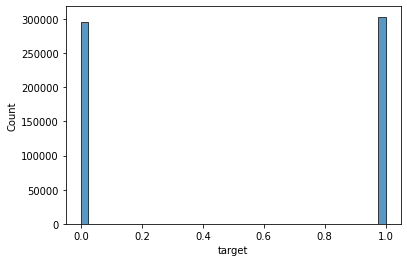

In [236]:
X = data.drop(columns=["target","id"])
y = data["target"]
sns.histplot(y);

In [237]:
# Create Sample datasets for quicker training
sample = data.sample(n=10000, random_state=1)
Xsamp = sample.drop(columns=["target",'id'])
ysamp = sample["target"]

In [245]:
# Scales and splits data into 80-20 train-val sets
# Scales all sets using scaler fitted on training set
def scaleSplit(X,y,X_test):
    X_train, X_val, y_train, y_val = train_test_split(X,y,train_size = .8, random_state=1)

    scaler = StandardScaler()

    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), columns = X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)
    
    return X_train, X_val, y_train, y_val, X_test

### Evaluation Environment and Baseline Testing
- The evaluation environment simply returns the accuracy and AUC score for a given model
- By looping through multiple classification models, we can see which performs best on the dataset
    - After choosing the basic model, we can tune hyperparameters to get better predictions

In [253]:
def evalEnv(model, X_train, y_train, X_val, y_val):
    clf = model
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    print(f"{model}\n AUC Score: {roc_auc_score(y_val, y_pred_val)}")
    print(f"Accuracy Score: {accuracy_score(y_val, y_pred_val)}\n")
    return clf

In [254]:
models = {  "Nearest Neighbors": KNeighborsClassifier(),
            "Logistic Regression": LogisticRegression(),
            "Linear SVM": SVC(),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(),
            "Neural Network": MLPClassifier(max_iter=500),
            "Naive Bayes": GaussianNB(),}

X_train, X_val, y_train, y_val, X_test = scaleSplit(Xsamp, ysamp, X_test)

for model in models:
    evalEnv(models[model], X_train, y_train, X_val, y_val)

KNeighborsClassifier()
 AUC Score: 0.5577631494650521
Accuracy Score: 0.557

LogisticRegression()
 AUC Score: 0.7109920558652061
Accuracy Score: 0.711

SVC()
 AUC Score: 0.6866751553590876
Accuracy Score: 0.6865

DecisionTreeClassifier()
 AUC Score: 0.5343271510026266
Accuracy Score: 0.5345

RandomForestClassifier()
 AUC Score: 0.6454689602152605
Accuracy Score: 0.645

MLPClassifier(max_iter=500)
 AUC Score: 0.5953536421295407
Accuracy Score: 0.595

GaussianNB()
 AUC Score: 0.583669677750016
Accuracy Score: 0.576



### Hyperparameter Tuning
- Logistic Regression scores the highest of any model without any tuning (0.71) on the sample set.
- After performing `GridSearchCV` with multiple different parameter combinations, none seemed to change the performance very much.
    - **max_iter: 5000** because lower values did not allow the model to converge
    - **solver: liblinear** performed slighlty better in previous GridCV testing
    - **penalty: l1** highest mean score in GridCV with C = 10
    - **C: 10** highest mean score in GridCV with penalty = l1

In [241]:
parameters = {'penalty': ['l1','l2'], 'C':[1,10,20]}
logReg = LogisticRegression(max_iter = 5000, solver= 'liblinear')
grid = GridSearchCV(logReg, parameters, cv=3)
grid.fit(X_train, y_train)
results = grid.cv_results_
df = pd.DataFrame(results)
bestParams = df[["param_penalty", 'param_C', 'mean_test_score']]
bestParams

,param_penalty,param_C,mean_test_score
0,l1,1,0.707875
1,l2,1,0.708125
2,l1,10,0.708250
3,l2,10,0.708125
4,l1,20,0.708125
5,l2,20,0.708125


### Final Model
- The final model performs slightly better on the full training set with an AUC score of 0.736
- Submitting to Kaggle, we get a score of 0.74545 on the test set.

In [258]:
X_train, X_val, y_train, y_val, X_test = scaleSplit(X, y, X_test)
hypelogReg = LogisticRegression(solver = 'liblinear', C = 10 , max_iter = 5000, penalty = 'l1')
final = evalEnv(hypelogReg, X_train, y_train, X_val, y_val)

LogisticRegression(C=10, max_iter=5000, penalty='l1', solver='liblinear')
 AUC Score: 0.7367832239399316
Accuracy Score: 0.736875



In [259]:
test_predictions = final.predict_proba(X_test)[:,1]
submission["target"] = test_predictions
submission

,id,target
0,600000,0.676706
1,600001,0.614298
2,600002,0.790162
3,600003,0.468759
4,600004,0.554166
...,...,...
539995,1139995,0.659889
539996,1139996,0.646935
539997,1139997,0.516683
539998,1139998,0.648693


In [244]:
#submission.to_csv("sub1.csv", index=False)

### Kaggle Submission
![](kaggle.png)